<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [2]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [3]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [4]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [5]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [6]:
# Defining parameters
kappa = 0.021  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [7]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.12 seconds


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Crank-Nicolson method took 0.26 seconds


and finally, plot the results side-by-side

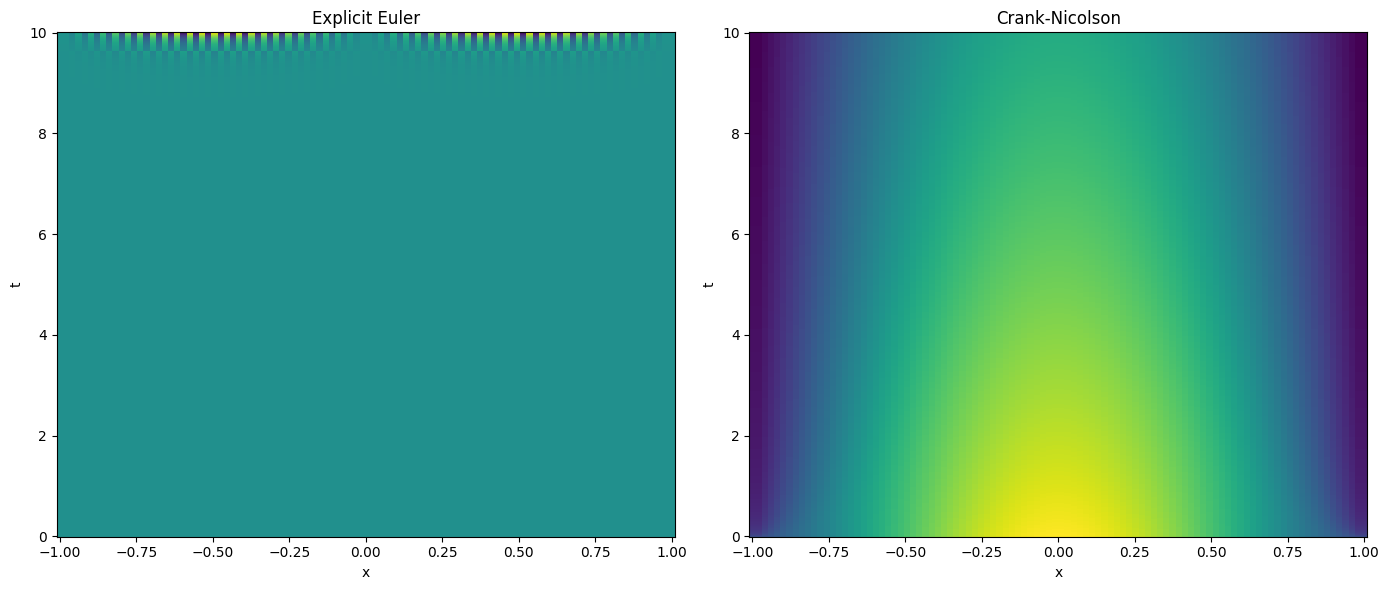

In [8]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing, $\Delta x$) and/or increase the diffusivity, $\kappa$, and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

# **[Unjin]**

Increasing Nx from 100 up to 451 does not make a significant difference between the graphs made by using the explicit Euler method and the Crank-Nicolson method, while from Nx = 452, graphs created by the explicit Euler method break and do not show a proper figure for the concentration. Therefore, the Euler method is unstable when Nx is larger than 451 with kappa = 0.001, while the Crank-Nicolson method is even stable for a larger Nx. Changing the diffusivity from 0.001 to 0.005 while Nx remains fixed at its original value, 100, results in a larger concentration in each point on the x-t plane for both of the methods, meaning the substance tends to spread more quickly with a larger diffusivity. However, for kappa = 0.006 and larger than 0.006, it is quite noticeable that the explicit Euler method creates graphs of a higher concentration in each (x,t) point than each point's concentration derived by the Crank-Nicolson method. From kappa = 0.021, the explicit Euler method starts to make broken graphs, which means the biggest number that kappa can take for the method to remain stable when Nx = 100 is around 0.021.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler method took 0.14 seconds
Crank-Nicolson method took 0.11 seconds


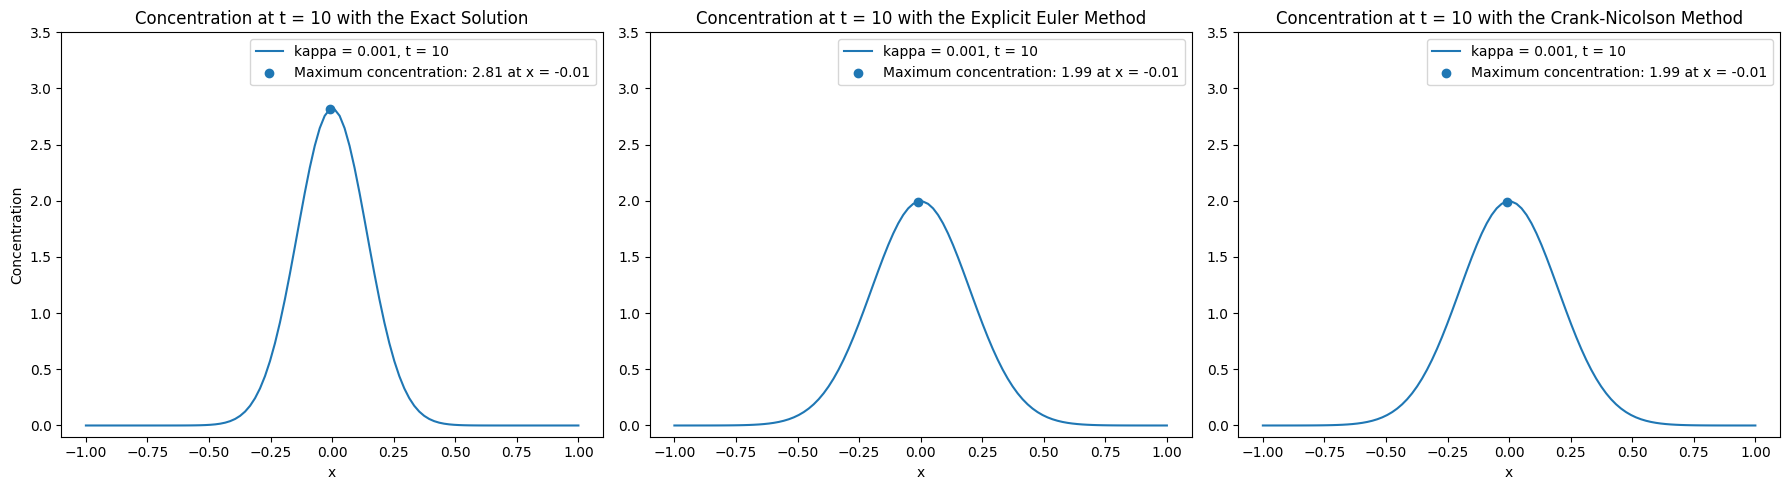

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.sparse as sp
import scipy.sparse.linalg as spla


kappa = 0.001
x = np.linspace(-1, 1, 100)
t_ic = 10


# The Exact Solution
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic
c_ic = set_ics(x, kappa, t_ic)
c_max_ic = c_ic.max()
x_max_ic = x[np.argmax(c_ic)]


# The Explicit Euler Method
def EE(x, t, kappa):
    start_time = time.time()
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)
    Nx = len(x); Nt = len(t)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
    M = sp.csr_matrix(M)
    c = np.zeros((Nx, Nt))
    c[:, 0] = set_ics(x, kappa, 10)
    for k in range(1, Nt):
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]
    end_time = time.time()
    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")
    return c
c_EE = EE(x, t, kappa)
c_max_EE = c_EE[:, -1].max()
max_index = np.unravel_index(np.argmax(c_EE), c_EE.shape)
x_max_EE = x[max_index[0]]


# The Crank-Nicolson Method
def CN(x, t, kappa):
    start_time = time.time()
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)
    Nx = len(x); Nt = len(t)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
    M = sp.csr_matrix(M)
    A = sp.eye(Nx) - 0.5 * dt * kappa * M
    A_inv = spla.inv(A)
    c = np.zeros((Nx, Nt))
    c[:, 0] = set_ics(x, kappa, 10)
    for k in range(1, Nt):
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]
    end_time = time.time()
    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")
    return c
c_CN = CN(x, t, kappa)
c_max_CN = c_CN[:, -1].max()
max_index = np.unravel_index(np.argmax(c_CN), c_CN.shape)
x_max_CN = x[max_index[0]]


# Figures
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(x, c_ic, label=f'kappa = {kappa}, t = {t_ic}')
axes[0].scatter(x_max_ic, c_max_ic, label=f'Maximum concentration: {c_max_ic:.2f} at x = {x_max_ic:.2f}')
axes[0].set_ylim(-0.1, 3.5)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Concentration")
axes[0].set_title("Concentration at t = 10 with the Exact Solution")
axes[0].legend(loc="upper right")

axes[1].plot(x, c_EE[:, -1], label=f'kappa = {kappa}, t = {t_ic}')
axes[1].scatter(x_max_EE, c_max_EE, label=f'Maximum concentration: {c_max_EE:.2f} at x = {x_max_EE:.2f}')
axes[1].set_ylim(-0.1, 3.5)
axes[1].set_xlabel("x")
axes[1].set_title("Concentration at t = 10 with the Explicit Euler Method")
axes[1].legend(loc="upper right")

axes[2].plot(x, c_CN[:, -1], label=f'kappa = {kappa}, t = {t_ic}')
axes[2].scatter(x_max_CN, c_max_CN, label=f'Maximum concentration: {c_max_CN:.2f} at x = {x_max_CN:.2f}')
axes[2].set_ylim(-0.1, 3.5)
axes[2].set_xlabel("x")
axes[2].set_title("Concentration at t = 10 with the Crank-Nicolson Method")
axes[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

# **[Unjin]**
Here, I have defined an error as the absolute difference between a concentration derived from the exact solution and a concentration from either the explicit Euler method or the Crank-Nicolson method. For the first graph where the x-axis is $\Delta x$, each error value was derived from the mean values in all of the x locations at t = 10.

Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.09 seconds
Crank-Nicolson method took 0.09 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.14 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.19 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.28 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.36 seconds
Explicit Euler method took 0.07 seconds
Crank-Nicolson method took 0.50 seconds
Explicit Euler method took 0.08 seconds
Crank-Nicolson method took 0.61 seconds


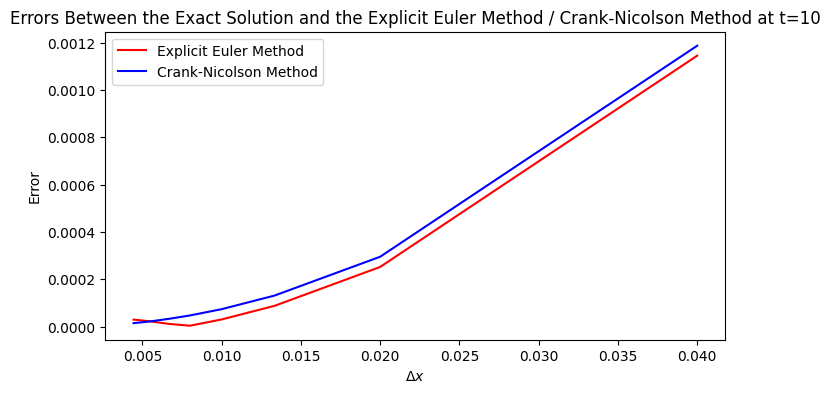

Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.01 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.02 seconds
Crank-Nicolson method took 0.03 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.19 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.10 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.03 seconds
Crank-Nicolson method took 0.04 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.05 seconds


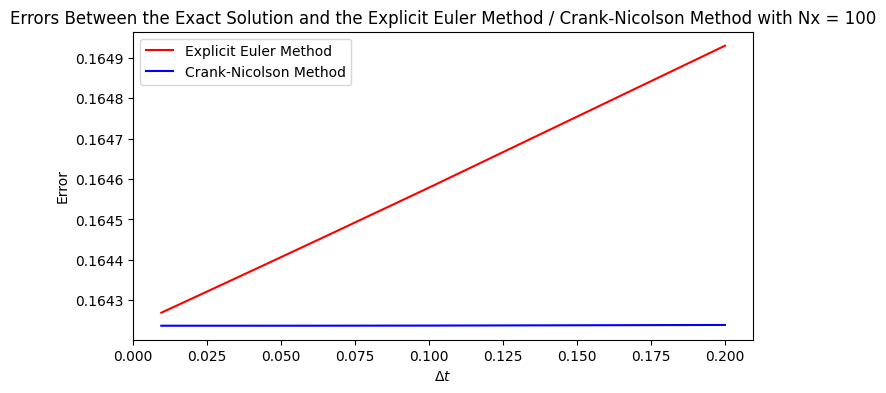

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.sparse as sp
import scipy.sparse.linalg as spla


kappa = 0.001
errs_EE_Nx = []
errs_CN_Nx = []
errs_EE_Nt = []
errs_CN_Nt = []


# As A Function of $\Delta x$
varying_Nx = range(50, 500, 50)
varying_del_x = [2 / Nx for Nx in varying_Nx]
t = np.linspace(0, 10, 1000)
for Nx in varying_Nx:
    x = np.linspace(-1, 1, Nx)
    c_EX = set_ics(x, kappa, 20)
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    err_EE = np.abs(c_EX - c_EE[:, -1]).mean()
    err_CN = np.abs(c_EX - c_CN[:, -1]).mean()
    errs_EE_Nx.append(err_EE)
    errs_CN_Nx.append(err_CN)


plt.figure(figsize=(8, 4))
plt.xlabel("$\Delta x$")
plt.ylabel("Error")
plt.plot(varying_del_x, errs_EE_Nx, label="Explicit Euler Method", color="red")
plt.plot(varying_del_x, errs_CN_Nx, label="Crank-Nicolson Method", color="blue")
plt.title("Errors Between the Exact Solution and the Explicit Euler Method / Crank-Nicolson Method at t=10")
plt.legend()
plt.show()


# As A Function of $\Delta t$
varying_Nt = range(50, 1100, 50)
varying_del_t = [10 / Nt for Nt in varying_Nt]
x = np.linspace(-1, 1, 100)


for Nt in varying_Nt:
    t = np.linspace(0, 10, Nt)
    #t_EX = t[-1]
    c_EX = set_ics(x, kappa, 10)
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    err_EE = np.abs(c_EX - c_EE[:, -1]).mean()
    err_CN = np.abs(c_EX - c_CN[:, -1]).mean()
    errs_EE_Nt.append(err_EE)
    errs_CN_Nt.append(err_CN)


plt.figure(figsize=(8, 4))
plt.xlabel("$\Delta t$")
plt.ylabel("Error")
plt.plot(varying_del_t, errs_EE_Nt, label="Explicit Euler Method", color="red")
plt.plot(varying_del_t, errs_CN_Nt, label="Crank-Nicolson Method", color="blue")
plt.title("Errors Between the Exact Solution and the Explicit Euler Method / Crank-Nicolson Method with Nx = 100")
plt.legend()
plt.show()

In [11]:
c_EE

array([[1.06483714e-10, 1.10620254e-10, 1.14812540e-10, ...,
        2.11036693e-05, 2.12198980e-05, 2.13366532e-05],
       [1.06483714e-10, 1.10620254e-10, 1.14812540e-10, ...,
        2.11036693e-05, 2.12198980e-05, 2.13366532e-05],
       [2.83577072e-10, 2.90100250e-10, 2.96794737e-10, ...,
        2.60796478e-05, 2.62184160e-05, 2.63577884e-05],
       ...,
       [2.83577072e-10, 2.90100250e-10, 2.96794737e-10, ...,
        2.60796478e-05, 2.62184160e-05, 2.63577884e-05],
       [1.06483714e-10, 1.10620254e-10, 1.14812540e-10, ...,
        2.11036693e-05, 2.12198980e-05, 2.13366532e-05],
       [1.06483714e-10, 1.10620254e-10, 1.14812540e-10, ...,
        2.11036693e-05, 2.12198980e-05, 2.13366532e-05]])

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?